In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 6)

In [2]:
import redis

cache_ip = '198.13.60.78'
cache_pw = 'da56038fa453c22d2c46e83179126e97d4d272d02ece83eb83a97357e842d065'

r = redis.StrictRedis(host=cache_ip, port=6379, password=cache_pw)

In [3]:
# redis keys
KOSPI_TICKERS = 'KOSPI_TICKERS'
KOSDAQ_TICKERS = 'KOSDAQ_TICKERS'

KOSPI_OHLCV = 'KOSPI_OHLCV'
KOSDAQ_OHLCV = 'KOSDAQ_OHLCV'
KOSPI_INDEX = 'I.001_INDEX'

KOSPI_VOL = 'KOSPI_VOL'
KOSDAQ_VOL = 'KOSDAQ_VOL'

kp_tickers = [ticker.decode() for ticker in r.lrange(KOSPI_TICKERS, 0 ,-1)]
kd_tickers = [ticker.decode() for ticker in r.lrange(KOSDAQ_TICKERS, 0 ,-1)]
tickers = kp_tickers + kd_tickers

In [6]:
# 포지션 관리
kp = pd.read_msgpack(r.get(KOSPI_INDEX))
kp = pd.DataFrame(kp['cls_prc'])
kp_ret = ((kp - kp.shift(1)) / kp.shift(1)).fillna(0)

수익률: cls_prc    0.12285
dtype: float64


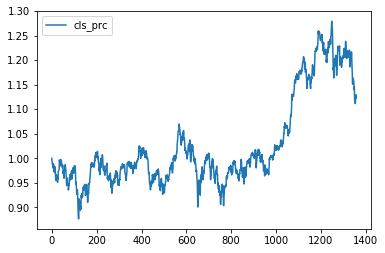

In [11]:
yc = (kp_ret + 1).cumprod()
print('수익률: {}'.format(yc.iloc[-1] - yc.iloc[0]))
yc.plot()
plt.show()

### System Stop

자신의 포트폴리오가 수익을 보고 있을때는 계속 트레이딩을 하고, 손실을 보고 있을때는 트레이딩 자체를 막아서 손실을 막는 방법이다. 시장에는 트렌드가 존재하기 때문에, 자신의 전략이 손실을 봤다는 것은 시장이 지속됨으로써 계속 손실을 볼 것이라는 가정하에 시스템 스탑을 하는 것이다.

In [13]:
yc.rename({'cls_prc': 'Yield'}, axis=1, inplace=True)

In [53]:
yc['Yield Short'] = yc['Yield'].rolling(5).mean()
yc['Yield Long'] = yc['Yield'].rolling(10).mean()
yc['System Stop'] = yc['Yield Short'] < yc['Yield Long']
yc['System Stop Price'] = ((yc['System Stop'] * 1) * yc['Yield']).replace(0, np.nan)

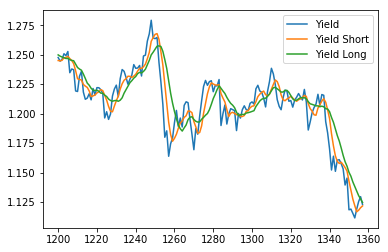

In [54]:
yc[['Yield', 'Yield Short', 'Yield Long']].iloc[1200:].plot()
plt.show()

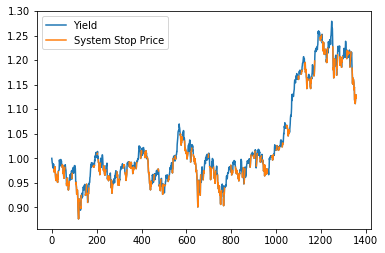

In [55]:
yc[['Yield', 'System Stop Price']].plot()
plt.show()

수익률: 0   -0.226938
dtype: float64


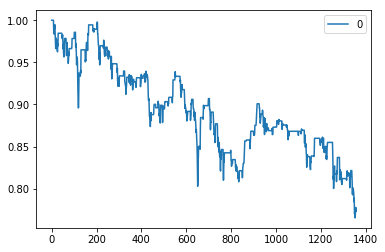

In [56]:
kp_sys_stop_ret = pd.DataFrame(kp_ret['cls_prc'] * (yc['System Stop'] * 1))
kp_sys_stop_ret = kp_sys_stop_ret.replace(-0, 0)
yc_sys_stop = (kp_sys_stop_ret + 1).cumprod()
print('수익률: {}'.format(yc_sys_stop.iloc[-1] - yc_sys_stop.iloc[0]))
yc_sys_stop.plot()
plt.show()

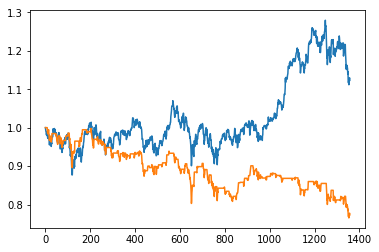

In [57]:
yc['Yield'].plot()
yc_sys_stop[0].plot()
plt.show()